In [2]:
import numpy as np
import gurobipy as gp
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from src.distance_matrix_to_artm_model import distance_matrix_to_artm_model
from src.distance_matrix_to_ertm_model import distance_matrix_to_ertm_model
from src.osmnx_to_distance_matrix import osmnx_to_distance_matrix
from src.osmnx_to_graph import osmnx_to_graph
from src.distance_matrix_with_demand_to_ertm_model import distance_matrix_with_demand_to_ertm_model

questions for Stefan: 
go over the osmnx_to_graph 
want to test the osmnx_to_graph_test function

want to test the distance_matrix_to_model function (is it working correctly)

in the model --> it took way too long.  is it because there is simply too much demand? how can i "light up" the nodes that the ambulances would be at? 


pos 180 = 4082716 UNIT? artm
pos 2 = 46355 UNIT artm (/ demand_vec) ~ 15

redundancy? make it so you get location --> distance matrix AND graph

understanding ertm model.

questions for me:
how can i quickly the long and lat for whatever it is I need? 

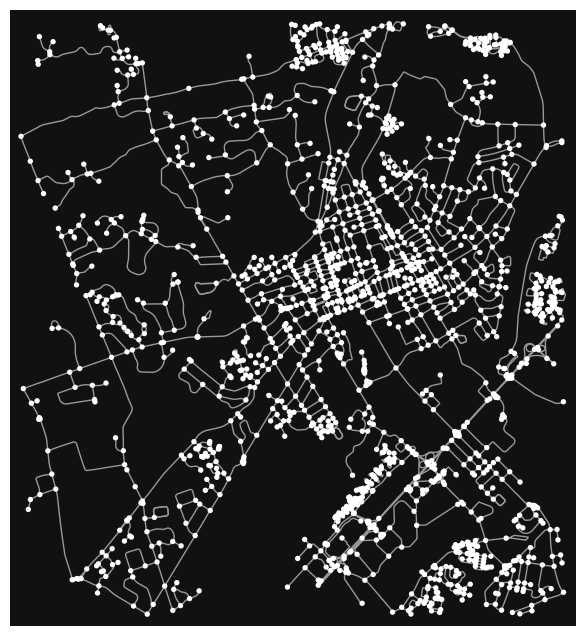

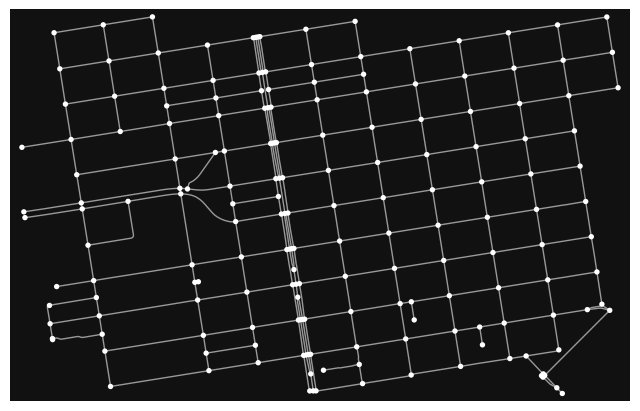

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
#test location --> graph
G_pton = osmnx_to_graph(location="Princeton, NJ", network_type='drive')
fig = ox.plot_graph(G_pton)

#Option 2: Using bounding box coordinates (minx, miny, maxx, maxy)
G_sf = osmnx_to_graph(bbox=(-122.43, 37.78, -122.41, 37.79))  # SF coordinates
ox.plot_graph(G_sf)

In [3]:
#test location --> dist matrix
D_pton = osmnx_to_distance_matrix(location="Princeton, NJ", network_type='drive')
print(D_pton.shape[0], D_pton.shape[1])
# Generate random intensity vector from Poisson distribution
demand_vec = np.random.poisson(lam=2, size=1583)
# Create and solve the model with p=5 ambulances
p = 2
model = distance_matrix_to_artm_model(D_pton, demand_vec, p)
# Optimize the model
model.optimize()
# Print objective value (average response time)
print(f"Average response time: {model.objVal}")

1583 1583
Set parameter Username
Set parameter LicenseID to value 2620847
Academic license - for non-commercial use only - expires 2026-02-11
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2507473 rows, 2507472 columns and 7519250 nonzeros
Model fingerprint: 0x13171626
Variable types: 0 continuous, 2507472 integer (2507472 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s)...
Presolve removed 0 rows and 0 columns (presolve time = 10s)...
Presolve time: 13.09s
Presolved: 2507473 rows, 2507472 columns, 7519250 nonzeros
Variable types: 0 continuous, 2507472 integer (2507472 binary)
Found heuristic solution: objective 80762.000000
Found heuristic solution: o


Ambulances are located at nodes: [28, 126]


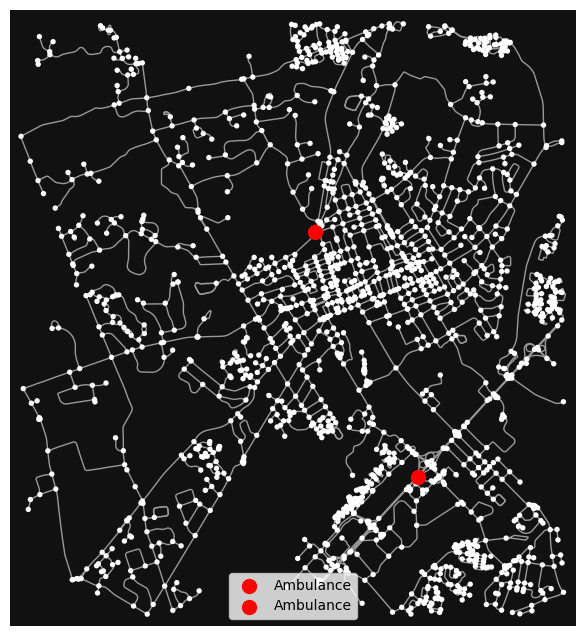

Ambulance at node 28: Lat=40.3251414, Lon=-74.6455959
Ambulance at node 126: Lat=40.361102, Lon=-74.665372


In [4]:
# Get the ambulance locations
ambulance_locations = []
for v in model.getVars():
    if v.varName.startswith('x[') and v.x > 0.9:  # Check x variables that are basically 1
        # Extract the index from variable name
        idx = int(v.varName.split('[')[1].split(']')[0])
        ambulance_locations.append(idx)

print(f"\nAmbulances are located at nodes: {ambulance_locations}")

# Get node coordinates for the ambulance locations
node_ids = list(G_pton.nodes())
ambulance_coords = [(G_pton.nodes[node_ids[loc]]['y'], G_pton.nodes[node_ids[loc]]['x']) 
                    for loc in ambulance_locations]

# Plot the graph with ambulance locations highlight
fig, ax = ox.plot_graph(G_pton, show=False, close=False)
for coord in ambulance_coords:
    ax.scatter(coord[1], coord[0], c='red', s=100, zorder=5, label='Ambulance')
plt.legend()
plt.show()

for loc in ambulance_locations:
    node = node_ids[loc]
    lat = G_pton.nodes[node]['y']
    lon = G_pton.nodes[node]['x']
    print(f"Ambulance at node {loc}: Lat={lat}, Lon={lon}")

In [5]:
print(46355 / np.sum(demand_vec))

14.32478368355995


In [6]:
D_pton = osmnx_to_distance_matrix(location="Princeton, NJ", network_type='drive')
print(D_pton.shape[0], D_pton.shape[1])
print(f"Min distance: {D_pton.min():.2f} meters")
print(f"Max distance: {D_pton.max():.2f} meters")
print(f"Mean distance: {D_pton.mean():.2f} meters")

# Check for any unusually large values
print(f"Number of distances > 10km: {np.sum(D_pton > 10000)}")

1583 1583
Min distance: 0.00 meters
Max distance: 71.00 meters
Mean distance: 27.52 meters
Number of distances > 10km: 0


Getting Princeton graph and distance matrix...
Matrix shape: (1583, 1583)

Creating and solving ERTM model...
Set parameter Username
Set parameter LicenseID to value 2620847
Academic license - for non-commercial use only - expires 2026-02-11
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[rosetta2] - Darwin 23.2.0 23C71)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2509056 rows, 5013361 columns and 12531028 nonzeros
Model fingerprint: 0x6728c853
Variable types: 0 continuous, 5013361 integer (5011778 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s)...
Presolve removed 0 rows and 0 columns (presolve time = 10s)...
Presolve removed 0 rows and 0 columns (presolve time = 15s)...
Presolve removed 0 rows and 0 columns (presolve time = 2

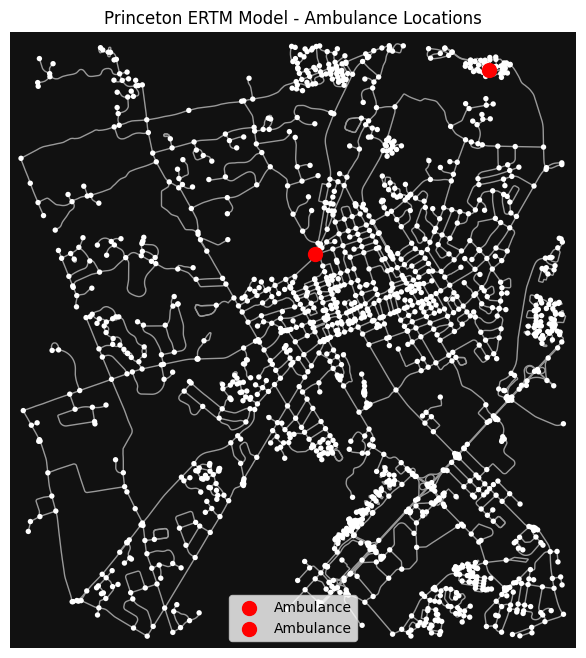

In [3]:
# Get Princeton graph and distance matrix
print('Getting Princeton graph and distance matrix...')
G_pton = osmnx_to_graph(location='Princeton, NJ', network_type='drive')
D_pton = osmnx_to_distance_matrix(location='Princeton, NJ', network_type='drive')
print(f'Matrix shape: {D_pton.shape}')

# Generate random demand vector (same as your ARTM test)
demand_vec = np.random.poisson(lam=2, size=D_pton.shape[0])

# Parameters for ERTM
p = 2  # Number of ambulances (same as your ARTM test)
q = 0.3  # Probability parameter for backup coverage

# Create and solve ERTM model
print('\nCreating and solving ERTM model...')
model = distance_matrix_to_ertm_model(D_pton, demand_vec, p, q)
model.optimize()

# Print results
print(f'\nERTM Results:')
print(f'Objective value (expected response time): {model.objVal}')

# Get ambulance locations
ambulance_locations = []
for v in model.getVars():
    if v.varName.startswith('x[') and v.x > 0.5:
        idx = int(v.varName.split('[')[1].split(']')[0])
        num_ambulances = int(v.x)
        print(f'Base {idx}: {num_ambulances} ambulance(s)')
        ambulance_locations.append(idx)

# Print coordinates and plot the results
node_ids = list(G_pton.nodes())
ambulance_coords = []

for loc in ambulance_locations:
    node = node_ids[loc]
    lat = G_pton.nodes[node]['y']
    lon = G_pton.nodes[node]['x']
    print(f'Ambulance at node {loc}: Lat={lat}, Lon={lon}')
    ambulance_coords.append((lat, lon))

# Plot the graph with ambulance locations highlighted
fig, ax = ox.plot_graph(G_pton, show=False, close=False)
for coord in ambulance_coords:
    ax.scatter(coord[1], coord[0], c='red', s=100, zorder=5, label='Ambulance')
plt.legend()
plt.title('Princeton ERTM Model - Ambulance Locations')
plt.show()

In [ ]:
# Example data
distance_matrix = ...  # Your distance matrix
intensity_vec = np.array([0.3, 0.7])  # Weights for response time objective
demand_vec = np.array([100, 200])     # Actual number of calls to serve
gamma_vec = np.array([10, 20])        # Priority weights (higher = more important to serve)
p = 5  # max ambulances
q = 0.3  # probability parameter

model = distance_matrix_with_demand_to_ertm_model(
    distance_matrix, 
    intensity_vec,
    demand_vec, 
    gamma_vec,
    p=5, 
    q=0.3
)